<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#用户价格弹性预测" data-toc-modified-id="用户价格弹性预测-1">用户价格弹性预测</a></span><ul class="toc-item"><li><span><a href="#正负样本生成" data-toc-modified-id="正负样本生成-1.1">正负样本生成</a></span></li><li><span><a href="#干预种类生成" data-toc-modified-id="干预种类生成-1.2">干预种类生成</a></span></li><li><span><a href="#用户特征生成" data-toc-modified-id="用户特征生成-1.3">用户特征生成</a></span></li><li><span><a href="#uplift模型训练" data-toc-modified-id="uplift模型训练-1.4">uplift模型训练</a></span></li><li><span><a href="#特征重要性及auuc" data-toc-modified-id="特征重要性及auuc-1.5">特征重要性及auuc</a></span></li><li><span><a href="#模型保存加载" data-toc-modified-id="模型保存加载-1.6">模型保存加载</a></span></li><li><span><a href="#单机上传至hdfs" data-toc-modified-id="单机上传至hdfs-1.7">单机上传至hdfs</a></span></li></ul></li></ul></div>

### 用户价格弹性预测

- 方式：预测不同折扣干预对用户转化率的影响

- 标签：分类建模，1表示转化购卡，0表示未转化购卡，则预估为正的softmax概率即为转化率

- 样本：曝光在用户面前的转化的折扣为正样本，曝光未转化的折扣为负样本

- 干预：不同的折扣力度，离散化为10个干预

- 特征：用户画像特征（年龄、性别、注册时间、城市、省份、战区...）、上下文特征（售卖位置、卡剩余次数、卡剩余天数...）、统计特征（订单、gmv...）

In [2]:
# 基础数据生成可看前三节内容
# 模型训练跳转uplift模型训练，所需数据（data0~9.csv）已就绪 

import pandas as pd
df= pd.read_csv('data0.csv')
print(df.shape)
df.columns

(100000, 71)

In [1]:
from helper.pandas_helper import *
from helper.presto_helper import *
# pd.set_option('display.max_columns', None)  # 列
# pd.set_option('display.max_rows', None)  # 行
import numpy as np
import pandas as pd
from functools import reduce

from causalml.dataset import make_uplift_classification
from causalml.inference.tree import UpliftRandomForestClassifier
from causalml.inference.tree import UpliftTreeClassifier
from causalml.metrics import plot_gain

from sklearn.model_selection import train_test_split

import causalml
causalml.__version__

import datetime
import warnings
from pyspark.sql import Row
from pyspark.sql import functions as F
from pyspark.conf import SparkConf
from pyspark.sql import SparkSession
warnings.filterwarnings("ignore")
from pyspark.sql.types import ArrayType, StructField, StructType, StringType, IntegerType, DecimalType, FloatType, LongType
from pyspark.sql.functions import broadcast, udf, pandas_udf, PandasUDFType, monotonically_increasing_id 

def open_spark_session(app_name="ai-train"):
    conf = (SparkConf().setMaster("local").setAppName(app_name).set("spark.yarn.queue", "online").set(
        "spark.sql.crossJoin.enabled", "true").set("hive.exec.dynamic.partition.mode", "nonstrict"))
    spark = SparkSession.builder.config(conf=conf).getOrCreate()
    return spark

spark = open_spark_session(app_name='yx')


/home/ai.liuxuanheng/.local/lib/python3.6/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/home/ai.liuxuanheng/.local/lib/python3.6/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
sklearn.tree._tree.TreeBuilder size changed, may indicate binary incompatibility. Expected 72 from C header, got 80 from PyObject


In [2]:
start = '20221201'
yyyymmdd = '20221227'

#### 正负样本生成

In [205]:
df = get_df_from_csv_table(query_presto(f"""
with start_price as (
-- 城市每日起步价信息
select 
  * 
from (
  select 
    *,
    ROW_NUMBER() OVER (partition by city_id,event_day order by base_meter_fee desc) rk
  from (
     select
        DISTINCT a.city_id,
        a.event_day,
        if(b.base_meter_fee=0,200,base_meter_fee) base_meter_fee --起步价
      from
        dwt.dwt_bd_order_detail_da a
        join dim.dim_order_fee_template_df b on a.city_id = b.city_id
        and a.event_day = b.event_day
        and a.price_strategy_id = b.template_id
      where
        a.event_day between '{start}' and  '{yyyymmdd}'  
        -- and a.city_id = 161
     )x
  )y where rk=1
),
buy_info as (
-- 城市每日购卡信息
  SELECT
    city_id,
    user_id,
    client_type,
    product_id,
    product_name,
    coupon_product_id,
    coupon_product_name,
    if(
      REGEXP_EXTRACT(coupon_product_name, '[减]') = '减',
      1,
      0
    ) is_minus_card,--区分次卡，立减卡
    display_index,
    original_rpice,--原始价格
    discount_price,--划线价格
    pay_amount, --实付价格
    pay_time,
    date_format(pay_time, '%Y%m%d') event_day
  from
    dwd.dwd_bd_atm_market_order_df
  where
    event_day = '{yyyymmdd}'  
    and date_format(pay_time, '%Y%m%d') between '{start}' and  '{yyyymmdd}'  
    and order_status = 2
    -- and city_id = 161
),
card_attr_info1 as (
--卡属性信息1（天数，次数、优惠等）
  SELECT
    id, -- 与buy_info中coupon_product_id品类id同含义，与card_attr_info2中product_id产品id同含义
    start_time,
    end_time,
    during_days,
    product_type,
    cast(
      json_extract_scalar(product_detail, '$.discount_rule') as int
    ) discount_rule,--抵扣方式1：每天  2：一共
    cast(
      json_extract_scalar(product_detail, '$.discount_total') as int
    ) discount_total,-- 每天使用次数 / 一共使用次数
    cast(
      json_extract_scalar(product_detail, '$.discount_amount') as int
    ) discount_amount, --每次抵扣金额
    event_day
  FROM
    dim.dim_atm_coupon_product_df --优惠券品类表
  where
    event_day  between '{start}' and  '{yyyymmdd}'  
),

positive_sample as (
--正样本
select
  *,
  if(
    is_minus_card = 0,
    discount_price * 1.00 / original_rpice, --次卡计算
    if( discount_rule=2,
        (discount_price * 1.00 / discount_total + (COALESCE(base_meter_fee,200) - discount_amount)) * 1.00 / COALESCE(base_meter_fee,200),
        (discount_price * 1.00 / (discount_total*during_days) + (COALESCE(base_meter_fee,200) - discount_amount)) * 1.00 / COALESCE(base_meter_fee,200)
        )  --立减卡计算
    ) discount_rate
from
  (
    select
      a.*,
      b.during_days,
      b.discount_rule,
      b.discount_total,
      b.discount_amount,
      c.base_meter_fee
    from
      buy_info a
      left join card_attr_info1 b on a.coupon_product_id = b.id and a.event_day=b.event_day
      left join start_price c on a.event_day=c.event_day and a.city_id=c.city_id
    -- where user_id = 39405749
  )x
  order by user_id
),

exposure_and_click as ( 
---用户售卖位曝光、售卖位点击数据
  SELECT 
    event_day,
    event,
    client_type,
    user_id,
    app_ver,
    city_id,
    city_name,
    brand,
    model,
    os,
    tm,
    val,
    json_extract_scalar(val,'$.position_id') position_id,
    json_extract_scalar(val,'$.position_name') position_name,
    json_extract_scalar(val,'$.goods_id') goods_id,
    json_extract_scalar(val,'$.goods_name') goods_name,
    if(
        REGEXP_EXTRACT(json_extract_scalar(val,'$.goods_name'), '[减]') = '减' or REGEXP_EXTRACT(json_extract_scalar(val,'$.goods_name'), '[限]') = '限' ,
      1,
      0
    ) is_minus_card--区分次卡，立减卡
  from 
    dwd.dwd_nf_nf_user_action_nm_da--量用户行为流表
  where 
    event_day  between '{start}' and  '{yyyymmdd}'  
    and event in('SalePositionExposure','SalePositionClick')
),
card_value_info as (
--卡价格信息
  SELECT
  id,-- 主键ID 等同exposure_and_click中goods_id商品id
  original_price,-- 商品原价
  --product_id,-- 商品ID
  --product_name,-- 商品名
  discount_price, -- 商品划线价
  coupon_package_id,
  event_day
FROM
  dim.dim_atm_market_product_df -- 商城商品配置
where
  event_day  between '{start}' and  '{yyyymmdd}' --and cast(date(create_time) as VARCHAR) = '2022-11-30'
),
card_attr_info2 as (
 --卡属性信息2（卡包id,产品id）
  SELECT
    coupon_package_id,-- 卡包ID
    product_id, -- 产品ID
    event_day
  FROM
    dim.dim_atm_coupon_package_item_df -- 营销卡包表
  where
    event_day  between '{start}' and  '{yyyymmdd}' 
),
card_info as (
-- 卡属性价格汇总
select 
    a.product_id,
    a.coupon_package_id,
    a.event_day,
    b.start_time,
    b.end_time,
    b.during_days,
    b.product_type,
    COALESCE(b.discount_rule,2) discount_rule,--抵扣方式1：每天  2：一共
    b.discount_total,-- 每天使用次数 / 一共使用次数
    COALESCE(b.discount_amount,200) discount_amount,
    c.id,
    c.original_price,
    c.discount_price
FROM
  card_attr_info2 a left join card_attr_info1 b
  on a.product_id = b.id and a.event_day=b.event_day join card_value_info c 
  on a.coupon_package_id=c.coupon_package_id and a.event_day=c.event_day
),
negative_sample as (
select 
    a.city_id,
    a.user_id,
    a.event_day,
    a.os,
    a.goods_id,
    a.goods_name,
    b.during_days,
    b.discount_rule,
    b.discount_total,
    b.discount_amount,
    b.original_price,
    b.discount_price,
    c.base_meter_fee,
    a.tm,
    if(
    is_minus_card = 0,
    discount_price * 1.00 / original_price, --次卡计算
    if( discount_rule=2,
        (discount_price * 1.00 / discount_total + (COALESCE(base_meter_fee,200) - discount_amount)) * 1.00 / COALESCE(base_meter_fee,200),
        (discount_price * 1.00 / (discount_total*during_days) + (COALESCE(base_meter_fee,200) - discount_amount)) * 1.00 / COALESCE(base_meter_fee,200)
        )  --立减卡计算
    ) discount_rate
from  
    exposure_and_click a  join card_info b 
    on a.goods_id=cast(b.id as VARCHAR) and a.event_day=b.event_day
    join start_price c on a.event_day=c.event_day and a.city_id=c.city_id
)

select
    a.*,b.buy_card,b.pay_time, 
    abs(hour(a.tm)*3600 + minute(a.tm)*60 + second(a.tm) - (hour(b.pay_time)*3600 + minute(b.pay_time)*60 + second(b.pay_time))) abs_scond ,
    if(b.buy_card=goods_name,1,0) is_buy
from (
     select 
         * 
     from 
         negative_sample 
     where 
         user_id in  (select distinct user_id from positive_sample) --筛购卡用户
     ) a 
left join 
    (
    select city_id,user_id,product_name buy_card,pay_time from positive_sample 
    ) b 
on 
    a.city_id=b.city_id and a.user_id=b.user_id 
    
-- where a.user_id in (57164557,20911364)
"""))


In [206]:
df.shape

(23564445, 19)

In [209]:
df.columns

Index(['city_id', 'user_id', 'event_day', 'os', 'goods_id', 'goods_name',
       'during_days', 'discount_rule', 'discount_total', 'discount_amount',
       'original_price', 'discount_price', 'base_meter_fee', 'tm',
       'discount_rate', 'buy_card', 'pay_time', 'abs_scond', 'is_buy'],
      dtype='object')

In [6]:
# 去重（骑行会有多次曝光，筛选出购卡时的曝光信息）
df = df[df.abs_scond<60]
df = df.drop_duplicates()
# 去低价（过滤低折扣）
df['discount_rate'] = df.discount_rate.astype('float')
df = df[df.discount_rate>0.4]
print(df.shape)

(3883027, 19)


In [7]:
# 正负样本量
df.groupby(['is_buy']).abs_scond.count()

is_buy
0    2272465
1    1610562
Name: abs_scond, dtype: int64

In [8]:
# 折扣范围
df.discount_rate.describe()

count    3.883027e+06
mean     6.913295e-01
std      1.018874e-01
min      4.100000e-01
25%      6.100000e-01
50%      7.000000e-01
75%      7.900000e-01
max      1.000000e+00
Name: discount_rate, dtype: float64

In [12]:
# 去无折扣样本
df[df.discount_rate!=1].discount_rate.describe()

count    3.883026e+06
mean     6.913294e-01
std      1.018873e-01
min      4.100000e-01
25%      6.100000e-01
50%      7.000000e-01
75%      7.900000e-01
max      8.883000e-01
Name: discount_rate, dtype: float64

#### 干预种类生成

In [13]:
# 离散化多个折扣率
fixed_rate_list = np.asarray([0.4,0.5,0.6,0.7,0.8,0.9])
# 多类teatment数据处理
df['fix_discount_rate'] = df.discount_rate.map(lambda x:fixed_rate_list[np.argmin(abs(x - fixed_rate_list))])
df.head()

,city_id,user_id,event_day,os,goods_id,goods_name,during_days,discount_rule,discount_total,discount_amount,original_price,discount_price,base_meter_fee,tm,discount_rate,buy_card,pay_time,abs_scond,is_buy,fix_discount_rate
1,372,20122090,20221215,,5946,畅骑40分,1,2,1,200,590,320,200,2022-12-15 22:32:37.000,0.5400,畅骑40分,2022-12-15 22:32:44.000,7.0,1,0.5
5,372,20122090,20221215,Android,5220,25天45次卡,25,2,45,200,9000,4530,200,2022-12-15 22:32:55.000,0.5000,畅骑40分,2022-12-15 22:32:44.000,11.0,0,0.5
12,74,84837131,20221215,Android,4922,5天2次卡,5,2,2,200,400,320,300,2022-12-15 22:53:38.000,0.8000,5天2次卡,2022-12-15 22:54:12.000,34.0,1,0.8
14,521,69122115,20221215,Android,5082,30天超值立减卡,30,2,30,100,3000,920,300,2022-12-15 22:45:25.000,0.7689,30天超值立减卡,2022-12-15 22:45:38.000,13.0,1,0.8
16,372,20122090,20221215,Android,5946,畅骑40分,1,2,1,200,590,320,200,2022-12-15 22:32:38.000,0.5400,畅骑40分,2022-12-15 22:32:44.000,6.0,1,0.5


In [14]:
# 不同折扣率样本量
df.groupby(['fix_discount_rate','is_buy']).is_buy.count()

fix_discount_rate  is_buy
0.4                0          66905
                   1           5957
0.5                0         168245
                   1          52156
0.6                0         732940
                   1         471785
0.7                0         726472
                   1         390899
0.8                0         553725
                   1         674641
0.9                0          24178
                   1          15124
Name: is_buy, dtype: int64

In [15]:
# 根据上述预设折扣率结果区分干预种类
treament_list = ['t1','t2','t3','t4','t5','control']
d = dict(zip(fixed_rate_list,treament_list))
print(d)
df['treatment_group_key'] = df.fix_discount_rate.map(lambda x:d.get(x))

{0.4: 't1', 0.5: 't2', 0.6: 't3', 0.7: 't4', 0.8: 't5', 0.9: 'control'}


In [18]:
# 手动平衡不同干预样本量
# print(df.groupby(['treatment_group_key','is_buy']).is_buy.count())

# control 不动
control = df[df.treatment_group_key=='control']

# t1 
t10 = df[(df.treatment_group_key=='t1')&(df.is_buy==0)].sample(frac=0.5)
t11 = df[(df.treatment_group_key=='t1')&(df.is_buy==1)]
t12 = df[(df.treatment_group_key=='t1')&(df.is_buy==1)]

# t2 
t20 = df[(df.treatment_group_key=='t2')&(df.is_buy==0)].sample(frac=0.5)
t21 = df[(df.treatment_group_key=='t2')&(df.is_buy==1)]

# t3 
t30 = df[(df.treatment_group_key=='t3')&(df.is_buy==0)].sample(frac=0.2)
t31 = df[(df.treatment_group_key=='t3')&(df.is_buy==1)].sample(frac=0.3)

# t4 
t40 = df[(df.treatment_group_key=='t4')&(df.is_buy==0)].sample(frac=0.2)
t41 = df[(df.treatment_group_key=='t4')&(df.is_buy==1)].sample(frac=0.3)

# t5 
t50 = df[(df.treatment_group_key=='t5')&(df.is_buy==0)].sample(frac=0.2)
t51 = df[(df.treatment_group_key=='t5')&(df.is_buy==1)].sample(frac=0.2)

res = [control,t10,t11,t12,t20,t21,t30,t31,t40,t41,t50,t51]
data = reduce(lambda x,y:pd.concat((x,y),axis=0),res)
print(data.shape,len(data.user_id.unique()))
print(data.groupby(['treatment_group_key','is_buy']).is_buy.count())

(1017307, 21) 419631
treatment_group_key  is_buy
control              0          24178
                     1          15124
t1                   0          33452
                     1          11914
t2                   0          84122
                     1          52156
t3                   0         146588
                     1         141536
t4                   0         145294
                     1         117270
t5                   0         110745
                     1         134928
Name: is_buy, dtype: int64


In [230]:
data.head()

,city_id,user_id,event_day,os,goods_id,goods_name,during_days,discount_rule,discount_total,discount_amount,original_price,discount_price,base_meter_fee,tm,discount_rate,buy_card,pay_time,abs_scond,is_buy,fix_discount_rate,treatment_group_key
3120,667,84474838,20221215,Android,5335,15天20次卡,15,2,20,200,4000,3480,300,2022-12-15 12:43:23.000,0.87,30天30次卡,2022-12-15 12:43:37.000,14.0,0,0.9,control
3307,178,17080903,20221218,Android,5331,5天5次卡,5,2,5,200,1000,880,250,2022-12-18 02:13:49.000,0.88,30天30次卡,2022-12-18 02:14:01.000,12.0,0,0.9,control
3315,91,61973950,20221214,Android,5331,5天5次卡,5,2,5,200,1000,880,250,2022-12-14 11:04:27.000,0.88,14天30次卡,2022-12-12 11:04:58.000,31.0,0,0.9,control
4956,340,66053465,20221222,Android,5335,15天20次卡,15,2,20,200,4000,3480,300,2022-12-22 09:06:07.000,0.87,5天5次卡,2022-12-22 09:06:21.000,14.0,0,0.9,control
6776,323,29547655,20221222,Android,5335,15天20次卡,15,2,20,200,4000,3480,300,2022-12-22 17:33:50.000,0.87,5天5次卡,2022-12-22 17:34:16.000,26.0,0,0.9,control


#### 用户特征生成 

In [21]:
# 特征
user_feature = get_df_from_csv_table(query_presto(f"""
with buy_info as (
-- 城市每日购卡信息
  SELECT
    distinct
    user_id
  from
    dwd.dwd_bd_atm_market_order_df
  where
    event_day =  '{yyyymmdd}' 
    and date_format(pay_time, '%Y%m%d') between '{start}' and  '{yyyymmdd}'  
    and order_status = 2
    -- and city_id = 161
),

user_statistic as (
 select 
     * 
 from 
     ai.dws_ai_smart_card_sale_user_feature_da
 where 
     event_day='20221228'
)

select 
    a.*,
    cast(json_extract_scalar(c.feature_json, '$.last_3d_mean_num') as double) last_3d_mean_num,
    cast(json_extract_scalar(c.feature_json, '$.last_5d_mean_num') as double) last_5d_mean_num,
    cast(json_extract_scalar(c.feature_json, '$.last_7d_mean_num') as double) last_7d_mean_num,
    cast(json_extract_scalar(c.feature_json, '$.last_10d_mean_num') as double) last_10d_mean_num,
    cast(json_extract_scalar(c.feature_json, '$.last_14d_mean_num') as double) last_14d_mean_num,
    cast(json_extract_scalar(c.feature_json, '$.last_21d_mean_num') as double) last_21d_mean_num,
    cast(json_extract_scalar(c.feature_json, '$.last_30d_mean_num') as double) last_30d_mean_num,
    
    cast(json_extract_scalar(c.feature_json, '$.last_3d_max_num') as double) last_3d_max_num,
    cast(json_extract_scalar(c.feature_json, '$.last_7d_max_num') as double) last_7d_max_num,
    cast(json_extract_scalar(c.feature_json, '$.last_14d_max_num') as double) last_14d_max_num,
    
    cast(json_extract_scalar(c.feature_json, '$.last_3d_min_num') as double) last_3d_min_num,
    cast(json_extract_scalar(c.feature_json, '$.last_7d_min_num') as double) last_7d_min_num,
    cast(json_extract_scalar(c.feature_json, '$.last_14d_min_num') as double) last_14d_min_num,
    
    cast(json_extract_scalar(c.feature_json, '$.last_1d_num') as double) last_1d_num,
    cast(json_extract_scalar(c.feature_json, '$.last_2d_num') as double) last_2d_num,
    cast(json_extract_scalar(c.feature_json, '$.last_3d_num') as double) last_3d_num,
    cast(json_extract_scalar(c.feature_json, '$.last_4d_num') as double) last_4d_num,
    cast(json_extract_scalar(c.feature_json, '$.last_5d_num') as double) last_5d_num,
    cast(json_extract_scalar(c.feature_json, '$.last_6d_num') as double) last_6d_num,
    cast(json_extract_scalar(c.feature_json, '$.last_7d_num') as double) last_7d_num,
    cast(json_extract_scalar(c.feature_json, '$.last_1w_same_day_num') as double) last_1w_same_day_num,
    cast(json_extract_scalar(c.feature_json, '$.last_2w_same_day_num') as double) last_2w_same_day_num,
    cast(json_extract_scalar(c.feature_json, '$.last_3w_same_day_num') as double) last_3w_same_day_num,
    cast(json_extract_scalar(c.feature_json, '$.last_4w_same_day_num') as double) last_4w_same_day_num,
    
    cast(json_extract_scalar(c.feature_json, '$.last_1w_buy_card_num') as double) last_1w_buy_card_num,
    cast(json_extract_scalar(c.feature_json, '$.last_2w_buy_card_num') as double) last_2w_buy_card_num,
    cast(json_extract_scalar(c.feature_json, '$.last_3w_buy_card_num') as double) last_3w_buy_card_num,
    cast(json_extract_scalar(c.feature_json, '$.last_4w_buy_card_num') as double) last_4w_buy_card_num,
    cast(json_extract_scalar(c.feature_json, '$.last_2m_buy_card_num') as double) last_2m_buy_card_num,
    cast(json_extract_scalar(c.feature_json, '$.last_3m_buy_card_num') as double) last_3m_buy_card_num, 
    
    cast(json_extract_scalar(c.feature_json, '$.latest_buy_during_day') as double) latest_buy_during_day, 
    cast(json_extract_scalar(c.feature_json, '$.latest_buy_during_num') as double) latest_buy_during_num, 
    cast(json_extract_scalar(c.feature_json, '$.latest_buy_original_price') as double) latest_buy_original_price, 
    cast(json_extract_scalar(c.feature_json, '$.latest_buy_discount_price') as double) latest_buy_discount_price, 
    cast(json_extract_scalar(c.feature_json, '$.latest_buy_discount_rate') as double) latest_buy_discount_rate, 
        
    cast(json_extract_scalar(c.feature_json, '$.most_buy_during_day') as double) most_buy_during_day, 
    cast(json_extract_scalar(c.feature_json, '$.most_buy_during_num') as double) most_buy_during_num, 
    cast(json_extract_scalar(c.feature_json, '$.most_buy_original_price') as double) most_buy_original_price, 
    cast(json_extract_scalar(c.feature_json, '$.most_buy_discount_price') as double) most_buy_discount_price, 
    cast(json_extract_scalar(c.feature_json, '$.most_buy_discount_rate') as double) most_buy_discount_rate, 
    
    cast(json_extract_scalar(c.feature_json, '$.mean_buy_during_day') as double) mean_buy_during_day, 
    cast(json_extract_scalar(c.feature_json, '$.mean_buy_during_num') as double) mean_buy_during_num, 
    cast(json_extract_scalar(c.feature_json, '$.mean_buy_original_price') as double) mean_buy_original_price, 
    cast(json_extract_scalar(c.feature_json, '$.mean_buy_discount_price') as double) mean_buy_discount_price, 
    cast(json_extract_scalar(c.feature_json, '$.mean_buy_discount_rate') as double) mean_buy_discount_rate, 
        
    cast(json_extract_scalar(c.feature_json, '$.age') as double) age, 
    cast(json_extract_scalar(c.feature_json, '$.gender') as double) gender, 
    cast(json_extract_scalar(c.feature_json, '$.age_span') as double) age_span, 
    cast(json_extract_scalar(c.feature_json, '$.register_span') as double) register_span
          
from 
    buy_info a join user_statistic c 
    on  a.user_id=c.user_id

"""))

In [24]:
user_feature.head()

,user_id,last_3d_mean_num,last_5d_mean_num,last_7d_mean_num,last_10d_mean_num,last_14d_mean_num,last_21d_mean_num,last_30d_mean_num,last_3d_max_num,last_7d_max_num,last_14d_max_num,last_3d_min_num,last_7d_min_num,last_14d_min_num,last_1d_num,last_2d_num,last_3d_num,last_4d_num,last_5d_num,last_6d_num,last_7d_num,last_1w_same_day_num,last_2w_same_day_num,last_3w_same_day_num,last_4w_same_day_num,last_1w_buy_card_num,last_2w_buy_card_num,last_3w_buy_card_num,last_4w_buy_card_num,last_2m_buy_card_num,last_3m_buy_card_num,latest_buy_during_day,latest_buy_during_num,latest_buy_original_price,latest_buy_discount_price,latest_buy_discount_rate,most_buy_during_day,most_buy_during_num,most_buy_original_price,most_buy_discount_price,most_buy_discount_rate,mean_buy_during_day,mean_buy_during_num,mean_buy_original_price,mean_buy_discount_price,mean_buy_discount_rate,age,gender,age_span,register_span
0,83859286,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.066667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,30.0,10.0,1000.0,390.0,0.695,30.0,10.0,1000.0,390.0,0.695,30.0,10.0,1000.0,390.0,0.695,40.0,2.0,4.0,4.0
1,84624006,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.033333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,5.0,2.0,400.0,320.0,0.800,5.0,2.0,400.0,320.0,0.800,5.0,2.0,400.0,320.0,0.800,43.0,1.0,4.0,3.0
2,20974188,0.0,0.2,0.142857,0.1,0.285714,0.238095,0.266667,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,15.0,8.0,1600.0,1010.0,0.631,15.0,8.0,1600.0,1010.0,0.631,15.0,8.0,1600.0,1010.0,0.631,40.0,2.0,4.0,7.0
3,54253107,0.0,0.2,0.142857,0.1,0.071429,0.047619,0.133333,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,2.0,3.0,600.0,400.0,0.667,2.0,3.0,600.0,400.0,0.667,8.0,5.0,1000.0,620.0,0.633,17.0,1.0,1.0,7.0
4,28132450,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.033333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,2.0,6.0,5.0,1000.0,700.0,0.700,4.0,3.0,600.0,420.0,0.700,5.0,4.0,800.0,560.0,0.700,46.0,1.0,5.0,7.0


In [25]:
combine = data.merge(user_feature,on = ['user_id'] ,how ='inner')
combine.shape

(1007608, 70)

#### uplift模型训练 

In [26]:
# train test
df_train, df_test = train_test_split(combine, test_size=0.2, random_state=111)
print(df_train.shape,df_test.shape)

x_names = ['age','gender','age_span','register_span',
           'last_3d_mean_num','last_5d_mean_num','last_7d_mean_num',
           'last_10d_mean_num','last_14d_mean_num',
           'last_30d_mean_num','last_1d_num','last_2d_num','last_3d_num',
          'last_4d_num','last_5d_num','last_6d_num','last_7d_num','last_1w_same_day_num',
          'last_2w_same_day_num','last_3w_same_day_num','last_4w_same_day_num',
           
           'last_1w_buy_card_num','last_2w_buy_card_num','last_3w_buy_card_num','last_4w_buy_card_num',
          'last_2m_buy_card_num','last_3m_buy_card_num',
          'latest_buy_during_day','latest_buy_during_num','latest_buy_original_price','latest_buy_discount_price','latest_buy_discount_rate',
          'most_buy_during_day','most_buy_during_num','most_buy_original_price','most_buy_discount_price','most_buy_discount_rate',
          'mean_buy_during_day','mean_buy_during_num','mean_buy_original_price','mean_buy_discount_price','mean_buy_discount_rate'

          ]

# uplift随机森林模型
uplift_model = UpliftRandomForestClassifier(control_name='control')
uplift_model.fit(df_train[x_names].values,
                 treatment=df_train['treatment_group_key'].values,
                 y=df_train['is_buy'].values)

# full_output 全部输出
# 包含了数据在对照和多种干预下的转化率；以及推荐的干预方式；以及每种干预相比对照的增量转化率；以及最大的增量值
df_res = uplift_model.predict(df_test[x_names].values, full_output=True) 

print(df_res.shape)
df_res.head()

(806086, 70) (201522, 70)
(201522, 13)


,control,t1,t2,t3,t4,t5,recommended_treatment,delta_t1,delta_t2,delta_t3,delta_t4,delta_t5,max_delta
0,0.007687,0.521111,0.758690,0.720811,0.082215,0.032545,t2,0.513423,0.751003,0.713124,0.074528,0.024858,0.751003
1,0.624492,0.010998,0.012057,0.047983,0.606554,0.531474,control,-0.613494,-0.612435,-0.576509,-0.017938,-0.093018,-0.017938
2,0.647760,0.009653,0.014210,0.042765,0.333253,0.681604,t5,-0.638107,-0.633550,-0.604995,-0.314507,0.033844,0.033844
3,0.020755,0.453814,0.688308,0.686761,0.149570,0.086971,t2,0.433059,0.667553,0.666006,0.128815,0.066216,0.667553
4,0.380911,0.079947,0.181414,0.475558,0.505913,0.256697,t4,-0.300964,-0.199497,0.094647,0.125002,-0.124214,0.125002


In [28]:
df_res.groupby(['recommended_treatment']).recommended_treatment.count()

recommended_treatment
control    31139
t2          7984
t3         83337
t4         29390
t5         49672
Name: recommended_treatment, dtype: int64

#### 特征重要性及auuc

<AxesSubplot:>

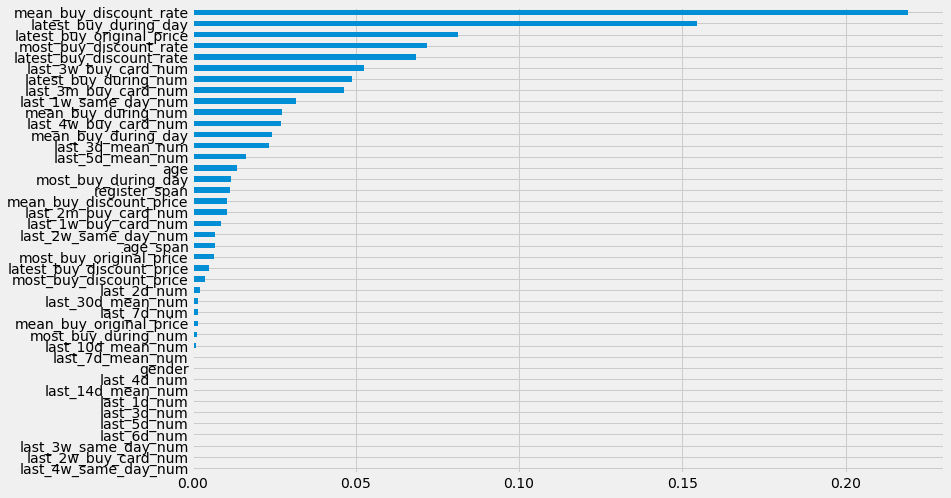

In [203]:
pd.Series(uplift_model.feature_importances_, index=x_names).sort_values().plot(kind='barh', figsize=(12,8))

In [30]:

# 预测默认输出 三种干预 相对对照组不干预的增量转化率
y_pred = uplift_model.predict(df_test[x_names].values)  
y_pred
# 整洁表示
result = pd.DataFrame(y_pred,columns=uplift_model.classes_[1:])
result.head()
# 如果增量都为负那么最好的一个动作就分配为对照，否则就分配最大的增量对应的干预

best_treatment = np.where((result < 0).all(axis=1),
                           'control',
                           result.idxmax(axis=1)) #返回每行比较的最大值的列名，axis=1按行比较

# 创建指示变量，以确定一个单元是否恰好具有推荐的处理方法或是否属于对照组

actual_is_best = np.where(df_test['treatment_group_key'] == best_treatment, 1, 0) # 是否推荐和实际干预处理/对照一致
actual_is_control = np.where(df_test['treatment_group_key'] == 'control', 1, 0) # 是否为对照数据
synthetic = (actual_is_best == 1) | (actual_is_control == 1)
synth = result[synthetic]   # 相当于把我们预测对的以及对照组数据拿出来
auuc_metrics = (synth.assign(is_treated = 1 - actual_is_control[synthetic], #该数据是否干预
                             conversion = df_test.loc[synthetic, 'is_buy'].values, #数据实际对应的转化情况
                             uplift_tree = synth.max(axis=1)) # 最高的增益数值
                     .drop(columns=list(uplift_model.classes_[1:])))

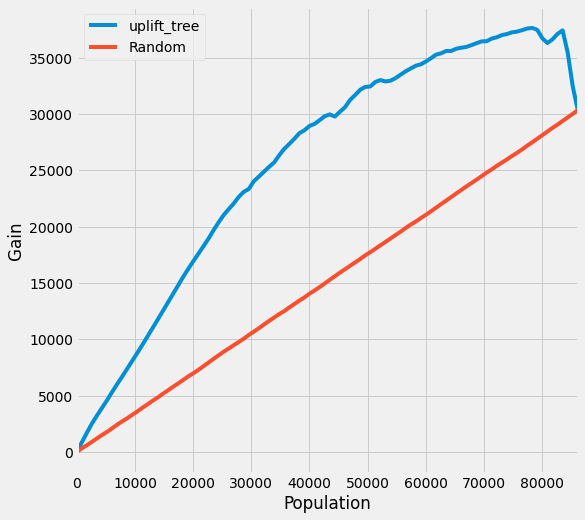

In [31]:
plot_gain(auuc_metrics, outcome_col='conversion', treatment_col='is_treated')

#### 模型保存加载

In [32]:
import pickle
with open('model_v2.pkl','wb') as f: 
    pickle.dump(uplift_model,f)

# 本地加载调用
with open('model_v1.pkl','rb') as f: 
    model = pickle.load(f)
model.predict(input_x,full_output=True)

# 集群
# 1.加载
model_path = 'hdfs:///data/ai/models/liuxuanheng/model_v2.pkl'
model_file = spark.sparkContext.binaryFiles(model_path)
file_name, file_content = model_file.first()
model = pickle.loads(file_content)
model_value = spark.sparkContext.broadcast(model)

# 2.rdd算子中预测
model2 = model_value.value
tmp_df = model2.predict(input_x,full_output=True)


#### 单机上传至hdfs

In [ ]:
hadoop fs -put model_v2.pkl hdfs:///data/ai/models/liuxuanheng/    